In [19]:
import pandas as pd
import numpy as np
from openpyxl import load_workbook
import os
import matplotlib.pyplot as plt
import urllib.request
import os

In [38]:
current_raw = pd.read_csv("data/downloaded_raw/Alameda_2008.csv")
#current_raw["tract_to_msamd_income"].unique()

/Users/ameliabaum/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [20]:
def tract_type(row):
    if (row["tract_to_msamd_income"] < 50):
        return "low"
    if (row["tract_to_msamd_income"] < 80):
        return "mod"
    if (row["tract_to_msamd_income"] <= 120):
        return "mid"
    if (row["tract_to_msamd_income"] > 120):
        return "high"
    else:
        return "not categorized"
    


In [21]:
def tract_eligibility(row):
    if (row["tract_to_msamd_income"] < 80):
        return "eligible"
    else:
        return "not eligible"

In [22]:
def borrower_eligibility(row):
    if (row["applicant_income_000s"]*1000 < .8*row["hud_median_family_income"]):
        return "eligfible"
    else:
        return "not eligible"


In [23]:
def add_year(df, year):
    df["Year"] = year
    

In [24]:
#calculates the proportion of loans in the dataset that go to each of the 4 person-place categories, returns an array of 
#4 proportions that correspond to each of the 4 categories
def people_vs_place(df):
    hb_lt = 0 
    hb_ht = 0
    lb_lt = 0
    lb_ht = 0
    for row in df.itertuples():
        cra_eligible_tract = row._48 #everytime the script is run these change.. ugh!
        cra_eligible_borrower = row._49

        if (cra_eligible_tract == "eligible" and cra_eligible_borrower == "eligible"):
            lb_lt +=1
            
        elif (cra_eligible_tract == "not eligible" and cra_eligible_borrower == "eligible"):
            lb_ht +=1
        elif (cra_eligible_tract == "eligible" and cra_eligible_borrower == "not eligible"):
            hb_lt +=1
        elif (cra_eligible_tract == "not eligible" and cra_eligible_borrower == "not eligible"):
            hb_ht +=1
        
    return [hb_lt/len(df), hb_lt, hb_ht/len(df), hb_ht, lb_lt/len(df), lb_lt, lb_ht/len(df), lb_ht]
    
        

In [25]:
bay_county_names = ["Alameda", "ContraCosta", "Sonoma", "Solano", "SanMateo", "SantaClara", "SanFrancisco", "Marin","Napa"] 
analysis_years = ["2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017"]


# bay_county_names = ["Alameda"]
# analysis_years = [2008]


In [26]:
#dataframes = []
def parse_data(df, year, county):
    df["CRA eligible tract"] = df.apply(lambda item: tract_eligibility(item), axis=1)
    df["CRA eligible borrower"] = df.apply(lambda item: borrower_eligibility(item), axis=1)
    df["type"] = df.apply(lambda item: tract_type(item), axis=1)
    df["Year"] = year
    df_lol = []
    for tract, tract_df in df.groupby("census_tract_number"):
        row_list = [tract, tract_df["Year"].iloc[0], tract_df["county_name"].iloc[0],
                    tract_df["type"].iloc[0], tract_df["CRA eligible tract"].iloc[0]]
        row_list.extend(people_vs_place(tract_df))
        df_lol.append(row_list)
    data = pd.DataFrame(df_lol, columns=["Tract", "Year", "County", "type", "CRA Eligible",'% HI borrower, LI tract', '# HI borrower, LI tract', 
                                         '% HI borrower, HI tract','# HI borrower, HI tract', "% LI borrower, LI tract", "# LI borrower, LI tract",
                                         "%LI borrower, HI tract", "# LI borrower, HI tract"])
    return data
        
        

In [27]:
#this takes awhile to run. Don't need to keep re-running it
filenames = []
tables_dict = {}
for county in bay_county_names: 
    for year in analysis_years:
        filename = "data/downloaded_raw/"+ county + "_"+ str(year)+ ".csv"
        filenames.append(filename)
        df = pd.read_csv(filename)
        new_frame = parse_data(df, year, county)
        tables_dict[county+ "_"+ str(year)] = new_frame
        print("writing..", county, year, " to csv")
        new_frame.to_csv("data/parsed_data/"+county+"_"+str(year)+"_parsed.csv")
        
        

/Users/ameliabaum/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


writing.. Alameda 2008  to csv


/Users/ameliabaum/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (29,30,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


writing.. Alameda 2009  to csv


/Users/ameliabaum/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (28,29,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


writing.. Alameda 2010  to csv


/Users/ameliabaum/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


writing.. Alameda 2011  to csv
writing.. Alameda 2012  to csv
writing.. Alameda 2013  to csv
writing.. Alameda 2014  to csv
writing.. Alameda 2015  to csv
writing.. Alameda 2016  to csv
writing.. Alameda 2017  to csv
writing.. ContraCosta 2008  to csv


/Users/ameliabaum/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


writing.. ContraCosta 2009  to csv
writing.. ContraCosta 2010  to csv


/Users/ameliabaum/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (30,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


writing.. ContraCosta 2011  to csv
writing.. ContraCosta 2012  to csv


/Users/ameliabaum/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (29,30,39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


writing.. ContraCosta 2013  to csv


/Users/ameliabaum/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


writing.. ContraCosta 2014  to csv


/Users/ameliabaum/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


writing.. ContraCosta 2015  to csv
writing.. ContraCosta 2016  to csv
writing.. ContraCosta 2017  to csv
writing.. Sonoma 2008  to csv
writing.. Sonoma 2009  to csv
writing.. Sonoma 2010  to csv
writing.. Sonoma 2011  to csv
writing.. Sonoma 2012  to csv
writing.. Sonoma 2013  to csv
writing.. Sonoma 2014  to csv
writing.. Sonoma 2015  to csv
writing.. Sonoma 2016  to csv
writing.. Sonoma 2017  to csv
writing.. Solano 2008  to csv
writing.. Solano 2009  to csv
writing.. Solano 2010  to csv
writing.. Solano 2011  to csv
writing.. Solano 2012  to csv
writing.. Solano 2013  to csv
writing.. Solano 2014  to csv
writing.. Solano 2015  to csv
writing.. Solano 2016  to csv
writing.. Solano 2017  to csv
writing.. SanMateo 2008  to csv
writing.. SanMateo 2009  to csv
writing.. SanMateo 2010  to csv
writing.. SanMateo 2011  to csv
writing.. SanMateo 2012  to csv
writing.. SanMateo 2013  to csv
writing.. SanMateo 2014  to csv
writing.. SanMateo 2015  to csv
writing.. SanMateo 2016  to csv
writing

/Users/ameliabaum/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (23,30) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


writing.. SantaClara 2009  to csv


/Users/ameliabaum/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (30,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


writing.. SantaClara 2010  to csv


/Users/ameliabaum/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (28,30) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


writing.. SantaClara 2011  to csv
writing.. SantaClara 2012  to csv


/Users/ameliabaum/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (30,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


writing.. SantaClara 2013  to csv
writing.. SantaClara 2014  to csv


/Users/ameliabaum/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (28,29,30,39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


writing.. SantaClara 2015  to csv


/Users/ameliabaum/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (28,29,30,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


writing.. SantaClara 2016  to csv


/Users/ameliabaum/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


writing.. SantaClara 2017  to csv
writing.. SanFrancisco 2008  to csv
writing.. SanFrancisco 2009  to csv
writing.. SanFrancisco 2010  to csv
writing.. SanFrancisco 2011  to csv
writing.. SanFrancisco 2012  to csv
writing.. SanFrancisco 2013  to csv
writing.. SanFrancisco 2014  to csv
writing.. SanFrancisco 2015  to csv
writing.. SanFrancisco 2016  to csv
writing.. SanFrancisco 2017  to csv
writing.. Marin 2008  to csv
writing.. Marin 2009  to csv
writing.. Marin 2010  to csv
writing.. Marin 2011  to csv
writing.. Marin 2012  to csv
writing.. Marin 2013  to csv
writing.. Marin 2014  to csv
writing.. Marin 2015  to csv
writing.. Marin 2016  to csv
writing.. Marin 2017  to csv
writing.. Napa 2008  to csv
writing.. Napa 2009  to csv
writing.. Napa 2010  to csv
writing.. Napa 2011  to csv
writing.. Napa 2012  to csv
writing.. Napa 2013  to csv
writing.. Napa 2014  to csv
writing.. Napa 2015  to csv
writing.. Napa 2016  to csv
writing.. Napa 2017  to csv


In [ ]:
#create a master reference dataframe that maps all census tracts in the bay to their type
files = [f for f in os.listdir("/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/data/downloaded_raw") if f[-3:] == "csv"]
dfs = []
for file in files:
    df = pd.read_csv("/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/data/parsed_data/"+file) 
    dflite = df[["Tract", "Tract type", "Year", "County", "CRA Eligible"]]
    dfs.append(df)
    master = pd.concat(dfs, axis=0)
    for tract, tract_df in dflite.groupby("Tract"):
        row_list = [tract, tract_df["Type"].iloc[0], tract_df["county_name"].iloc[0],
                    tract_df["Tract type"].iloc[0], tract_df["CRA eligible tract"].iloc[0]]
    




In [64]:
df= pd.read_csv("/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/data/parsed_data/Alameda_2008_parsed.csv") 
dflite = df[["Tract", "Tract type", "Year", "County", "CRA Eligible"]]
#dflite.groupby(["Tract", "Tract type", "Year", "County", "CRA Eligible"], axis=0)
dflite

,Tract,Tract type,Year,County,CRA Eligible
0,4001.00,high,2008,Alameda County,not eligible
1,4002.00,high,2008,Alameda County,not eligible
2,4003.00,mid,2008,Alameda County,not eligible
3,4004.00,mid,2008,Alameda County,not eligible
4,4005.00,mod,2008,Alameda County,eligible
5,4006.00,mod,2008,Alameda County,eligible
6,4007.00,mod,2008,Alameda County,eligible
7,4008.00,mod,2008,Alameda County,eligible
8,4009.00,mod,2008,Alameda County,eligible
9,4010.00,low,2008,Alameda County,eligible


In [17]:
master.to_csv("tracts_type_master.csv")

In [117]:
#write a function that will create 4 dataframes for each county, one for each of the person/place categories. 
county_person_place = {}
for county in bay_county_names:
    years_df_hb_lt = []
    years_df_hb_ht = []
    years_df_lb_lt = []
    years_df_lb_ht = []
    for year in analysis_years:
        years_df_hb_lt.append(tables_dict[county+ "_"+ year][['Tract', 'Year', 'County','HI borrower, LI tract']])
        years_df_hb_ht.append(tables_dict[county+ "_"+ year][['Tract', 'Year', 'County','HI borrower, HI tract']])
        years_df_lb_lt.append(tables_dict[county+ "_"+ year][['Tract', 'Year', 'County','LI borrower, LI tract']])
        years_df_lb_ht.append(tables_dict[county+ "_"+ year][['Tract', 'Year', 'County','LI borrower, HI tract']])  
    county_person_place[county+"_hb_lt"] = pd.concat(years_df_hb_lt, axis=0)
    county_person_place[county+"_hb_ht"] = pd.concat(years_df_hb_ht, axis=0)
    county_person_place[county+"_lb_lt"] = pd.concat(years_df_lb_lt, axis=0)
    county_person_place[county+"_lb_ht"] = pd.concat(years_df_lb_ht, axis=0)
        
        


4046.0


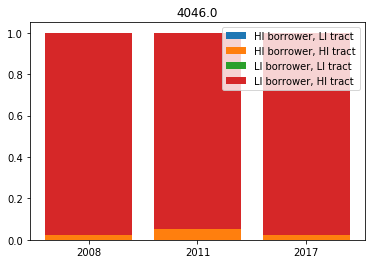

4515.03


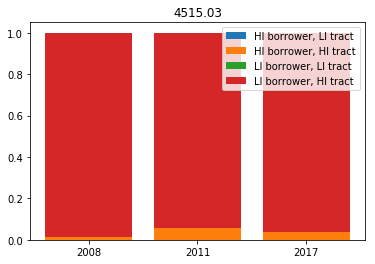

4231.0


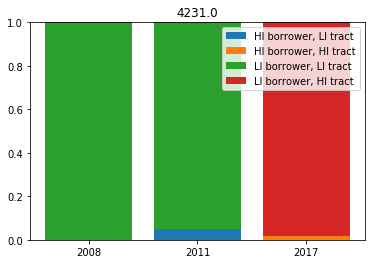

4051.0


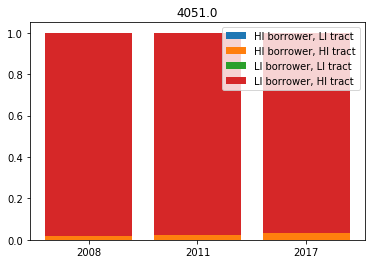

4312.0


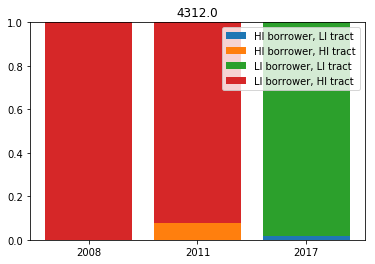

4042.0


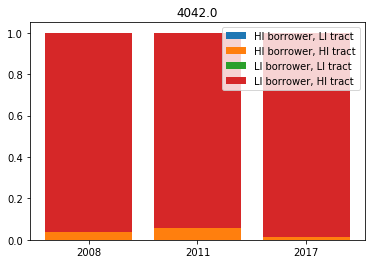

4095.0


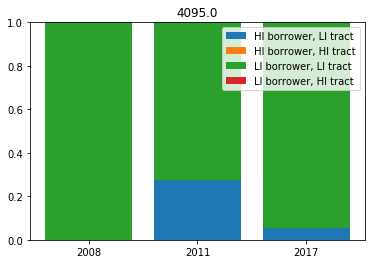

In [118]:
for i in range(7):
    tract = county_person_place["Alameda_hb_lt"].sample()["Tract"].values[0]
    print(tract)
    foo_hblt = county_person_place["Alameda_hb_lt"][county_person_place["Alameda_hb_lt"]["Tract"] == tract]
    foo_hbht = county_person_place["Alameda_hb_ht"][county_person_place["Alameda_hb_ht"]["Tract"] == tract]
    foo_lblt = county_person_place["Alameda_lb_lt"][county_person_place["Alameda_lb_lt"]["Tract"] == tract]
    foo_lbht = county_person_place["Alameda_lb_ht"][county_person_place["Alameda_lb_ht"]["Tract"] == tract]
    p1 = plt.bar(foo_hblt["Year"], foo_hblt["HI borrower, LI tract"])
    p2 = plt.bar(foo_hbht["Year"], foo_hbht["HI borrower, HI tract"], bottom=foo_hblt["HI borrower, LI tract"])
    p3 = plt.bar(foo_lblt["Year"], foo_lblt["LI borrower, LI tract"], bottom=foo_hblt["HI borrower, LI tract"]+foo_hbht["HI borrower, HI tract"])
    p4 = plt.bar(foo_lbht["Year"], foo_lbht["LI borrower, HI tract"], bottom=foo_hblt["HI borrower, LI tract"]+foo_hbht["HI borrower, HI tract"]+foo_lblt["LI borrower, LI tract"])

    # plt.plot(foo_hblt["Year"], foo_hblt["HI borrower, LI tract"])
    # plt.plot(foo_hbht["Year"], foo_hbht["HI borrower, HI tract"])
    # plt.plot(foo_lblt["Year"], foo_lblt["LI borrower, LI tract"])
    # plt.plot(foo_lbht["Year"], foo_lbht["LI borrower, HI tract"])
    plt.legend((p1[0], p2[0], p3[0], p4[0]), ('HI borrower, LI tract', 'HI borrower, HI tract', "LI borrower, LI tract", "LI borrower, HI tract"))
    plt.title(tract)
    plt.show()
